In [1]:
import numpy as np
import numpy.linalg as la
import pyopencl as cl
import pyopencl.array as cl_array
from tqdm import tqdm
import time
from contextlib import contextmanager
from functools import reduce
import math
from pprint import pprint
import matplotlib.pyplot as plt

In [2]:
platforms = cl.get_platforms()

def get_platform_info(platform):
    keys = [
        "EXTENSIONS",
        "EXTENSIONS_WITH_VERSION",
        "HOST_TIMER_RESOLUTION",
        "NAME",
        "NUMERIC_VERSION",
        "PROFILE",
        "VENDOR",
        "VERSION",
    ]
    info = {}
    for key in keys:
        try:
            value = platform.get_info(getattr(cl.platform_info, key))
            info.setdefault(key.lower(), value)
        except:
            pass
    return info

platform_infos = list(map(get_platform_info, platforms))
if len(platforms) > 1:
    print(f"> Listing platforms ({len(platforms)})")
    pprint(platform_infos)

platform_index = 0
platform = platforms[platform_index]
platform_info = platform_infos[platform_index]

print(f"> Selected platform ({platform_index})")
pprint(platform_info)

def get_device_info(device):
    keys = [
        "ADDRESS_BITS",
        "ATOMIC_FENCE_CAPABILITIES",
        "ATOMIC_MEMORY_CAPABILITIES",
        "ATTRIBUTE_ASYNC_ENGINE_COUNT_NV",
        "AVAILABLE",
        "AVAILABLE_ASYNC_QUEUES_AMD",
        "BOARD_NAME_AMD",
        "BUILT_IN_KERNELS",
        "BUILT_IN_KERNELS_WITH_VERSION",
        "COMPILER_AVAILABLE",
        "COMPUTE_CAPABILITY_MAJOR_NV",
        "COMPUTE_CAPABILITY_MINOR_NV",
        "DEVICE_ENQUEUE_CAPABILITIES",
        "DOUBLE_FP_CONFIG",
        "DRIVER_VERSION",
        "ENDIAN_LITTLE",
        "ERROR_CORRECTION_SUPPORT",
        "EXECUTION_CAPABILITIES",
        "EXTENSIONS",
        "EXTENSIONS_WITH_VERSION",
        "EXT_MEM_PADDING_IN_BYTES_QCOM",
        "GENERIC_ADDRESS_SPACE_SUPPORT",
        "GFXIP_MAJOR_AMD",
        "GFXIP_MINOR_AMD",
        "GLOBAL_FREE_MEMORY_AMD",
        "GLOBAL_MEM_CACHELINE_SIZE",
        "GLOBAL_MEM_CACHE_SIZE",
        "GLOBAL_MEM_CACHE_TYPE",
        "GLOBAL_MEM_CHANNELS_AMD",
        "GLOBAL_MEM_CHANNEL_BANKS_AMD",
        "GLOBAL_MEM_CHANNEL_BANK_WIDTH_AMD",
        "GLOBAL_MEM_SIZE",
        "GLOBAL_VARIABLE_PREFERRED_TOTAL_SIZE",
        "GPU_OVERLAP_NV",
        "HALF_FP_CONFIG",
        "HOST_UNIFIED_MEMORY",
        "ILS_WITH_VERSION",
        "IL_VERSION",
        "IMAGE2D_MAX_HEIGHT",
        "IMAGE2D_MAX_WIDTH",
        "IMAGE3D_MAX_DEPTH",
        "IMAGE3D_MAX_HEIGHT",
        "IMAGE3D_MAX_WIDTH",
        "IMAGE_BASE_ADDRESS_ALIGNMENT",
        "IMAGE_MAX_ARRAY_SIZE",
        "IMAGE_MAX_BUFFER_SIZE",
        "IMAGE_PITCH_ALIGNMENT",
        "IMAGE_SUPPORT",
        "INTEGRATED_MEMORY_NV",
        "KERNEL_EXEC_TIMEOUT_NV",
        "LINKER_AVAILABLE",
        "LOCAL_MEM_BANKS_AMD",
        "LOCAL_MEM_SIZE",
        "LOCAL_MEM_SIZE_PER_COMPUTE_UNIT_AMD",
        "LOCAL_MEM_TYPE",
        "MAX_ATOMIC_COUNTERS_EXT",
        "MAX_CLOCK_FREQUENCY",
        "MAX_COMPUTE_UNITS",
        "MAX_CONSTANT_ARGS",
        "MAX_CONSTANT_BUFFER_SIZE",
        "MAX_GLOBAL_VARIABLE_SIZE",
        "MAX_MEM_ALLOC_SIZE",
        "MAX_NUM_SUB_GROUPS",
        "MAX_ON_DEVICE_EVENTS",
        "MAX_ON_DEVICE_QUEUES",
        "MAX_PARAMETER_SIZE",
        "MAX_PIPE_ARGS",
        "MAX_READ_IMAGE_ARGS",
        "MAX_READ_WRITE_IMAGE_ARGS",
        "MAX_SAMPLERS",
        "MAX_WORK_GROUP_SIZE",
        "MAX_WORK_GROUP_SIZE_AMD",
        "MAX_WORK_ITEM_DIMENSIONS",
        "MAX_WORK_ITEM_SIZES",
        "MAX_WRITE_IMAGE_ARGS",
        "MEM_BASE_ADDR_ALIGN",
        "ME_VERSION_INTEL",
        "MIN_DATA_TYPE_ALIGN_SIZE",
        "NAME",
        "NATIVE_VECTOR_WIDTH_CHAR",
        "NATIVE_VECTOR_WIDTH_DOUBLE",
        "NATIVE_VECTOR_WIDTH_FLOAT",
        "NATIVE_VECTOR_WIDTH_HALF",
        "NATIVE_VECTOR_WIDTH_INT",
        "NATIVE_VECTOR_WIDTH_LONG",
        "NATIVE_VECTOR_WIDTH_SHORT",
        "NON_UNIFORM_WORK_GROUP_SUPPORT",
        "NUMERIC_VERSION",
        "NUM_SIMULTANEOUS_INTEROPS_INTEL",
        "OPENCL_C_ALL_VERSIONS",
        "OPENCL_C_FEATURES",
        "OPENCL_C_VERSION",
        "PAGE_SIZE_QCOM",
        "PARENT_DEVICE",
        "PARTITION_AFFINITY_DOMAIN",
        "PARTITION_MAX_SUB_DEVICES",
        "PARTITION_PROPERTIES",
        "PARTITION_TYPE",
        "PCIE_ID_AMD",
        "PCI_BUS_ID_NV",
        "PCI_DOMAIN_ID_NV",
        "PCI_SLOT_ID_NV",
        "PIPE_MAX_ACTIVE_RESERVATIONS",
        "PIPE_MAX_PACKET_SIZE",
        "PIPE_SUPPORT",
        "PLATFORM",
        "PREFERRED_CONSTANT_BUFFER_SIZE_AMD",
        "PREFERRED_GLOBAL_ATOMIC_ALIGNMENT",
        "PREFERRED_INTEROP_USER_SYNC",
        "PREFERRED_LOCAL_ATOMIC_ALIGNMENT",
        "PREFERRED_PLATFORM_ATOMIC_ALIGNMENT",
        "PREFERRED_VECTOR_WIDTH_CHAR",
        "PREFERRED_VECTOR_WIDTH_DOUBLE",
        "PREFERRED_VECTOR_WIDTH_FLOAT",
        "PREFERRED_VECTOR_WIDTH_HALF",
        "PREFERRED_VECTOR_WIDTH_INT",
        "PREFERRED_VECTOR_WIDTH_LONG",
        "PREFERRED_VECTOR_WIDTH_SHORT",
        "PREFERRED_WORK_GROUP_SIZE_AMD",
        "PREFERRED_WORK_GROUP_SIZE_MULTIPLE",
        "PRINTF_BUFFER_SIZE",
        "PROFILE",
        "PROFILING_TIMER_OFFSET_AMD",
        "PROFILING_TIMER_RESOLUTION",
        "QUEUE_ON_DEVICE_MAX_SIZE",
        "QUEUE_ON_DEVICE_PREFERRED_SIZE",
        "QUEUE_ON_DEVICE_PROPERTIES",
        "QUEUE_ON_HOST_PROPERTIES",
        "QUEUE_PROPERTIES",
        "REFERENCE_COUNT",
        "REGISTERS_PER_BLOCK_NV",
        "SIMD_INSTRUCTION_WIDTH_AMD",
        "SIMD_PER_COMPUTE_UNIT_AMD",
        "SIMD_WIDTH_AMD",
        "SIMULTANEOUS_INTEROPS_INTEL",
        "SINGLE_FP_CONFIG",
        "SPIR_VERSIONS",
        "SUB_GROUP_INDEPENDENT_FORWARD_PROGRESS",
        "SVM_CAPABILITIES",
        "THREAD_TRACE_SUPPORTED_AMD",
        "TOPOLOGY_AMD",
        "TYPE",
        "VENDOR",
        "VENDOR_ID",
        "VERSION",
        "WARP_SIZE_NV",
        "WAVEFRONT_WIDTH_AMD",
        "WORK_GROUP_COLLECTIVE_FUNCTIONS_SUPPORT",
    ]
    info = {}
    for key in keys:
        try:
            value = device.get_info(getattr(cl.device_info, key))
            info.setdefault(key.lower(), value)
        except:
            pass
    return info

devices = platform.get_devices()
device_infos = list(map(get_device_info, devices))
if len(devices) > 1:
    print(f"> Listing devices ({len(devices)})")
    pprint(device_infos)

device_index = 0
device = devices[device_index]
device_info = device_infos[device_index]

print(f"> Selected device ({device_index})")
pprint(device_info)

context = cl.Context(devices=[device])

> Selected platform (0)
{'extensions': 'cl_khr_icd cl_khr_d3d10_sharing cl_khr_d3d11_sharing '
               'cl_khr_dx9_media_sharing cl_amd_event_callback '
               'cl_amd_offline_devices ',
 'host_timer_resolution': 100,
 'name': 'AMD Accelerated Parallel Processing',
 'profile': 'FULL_PROFILE',
 'vendor': 'Advanced Micro Devices, Inc.',
 'version': 'OpenCL 2.1 AMD-APP (3628.0)'}
> Selected device (0)
{'address_bits': 64,
 'available': 1,
 'available_async_queues_amd': 2,
 'board_name_amd': 'AMD Radeon(TM) Graphics',
 'built_in_kernels': '',
 'compiler_available': 1,
 'double_fp_config': 63,
 'driver_version': '3628.0 (PAL,LC)',
 'endian_little': 1,
 'error_correction_support': 0,
 'execution_capabilities': 1,
 'extensions': 'cl_khr_fp64 cl_khr_global_int32_base_atomics '
               'cl_khr_global_int32_extended_atomics '
               'cl_khr_local_int32_base_atomics '
               'cl_khr_local_int32_extended_atomics cl_khr_int64_base_atomics '
               'cl_k

In [3]:
class NanoTimer:
    def __init__(self):
        self.start_ns = None
        self.end_ns = None
    
    def __enter__(self):
        self.start_ns = time.time_ns()
        return self

    def __exit__(self, *args):
        self.end_ns = time.time_ns()        

    def get_delta_ns(self):
        return self.end_ns - self.start_ns

In [4]:
max_compute_units = device_info["max_compute_units"]
workgroups_per_compute_unit = 2048
max_workgroup_threads = device_info["max_work_group_size"]
max_mem_alloc_size = device_info["max_mem_alloc_size"]

sizeof_type = 4
max_global_threads = max_compute_units*workgroups_per_compute_unit*max_workgroup_threads
max_global_threads = min(max_global_threads*sizeof_type, max_mem_alloc_size) // sizeof_type
max_global_threads = (max_global_threads//max_workgroup_threads) * max_workgroup_threads
print(max_global_threads, max_workgroup_threads)

3145728 256


In [5]:
# compute_complexity = 16
compute_complexity = 4096
# compute_complexity = 4096*8
flops_per_cell = 4

program_source = f"""
    __kernel void sum(__global float *y) {{
        int i = get_global_id(0);
        float a = (float)(i);
        float b = 1.3f;
        for (int j = 0; j < {compute_complexity}; j++) {{
            //a = b*a + b;
            //b = a*b + a;
            a = mad(b,a,b);
            b = mad(a,b,a);
        }}
        y[i] = b;
    }}
"""

gpu_program = cl.Program(context, program_source).build()
gpu_sum = gpu_program.sum

rng = np.random.default_rng()
grid_size = (max_global_threads,)
# grid_size = (max_workgroup_threads*2048*6,)
data_shape = grid_size
workgroup_size = (max_workgroup_threads,)
max_workgroup_size = device_info["max_work_group_size"]
workgroup_size_count = reduce(lambda x,y: x*y, workgroup_size, 1)
assert(workgroup_size_count <= max_workgroup_size)
dispatch_size = [math.ceil(x/y) for x,y in zip(grid_size, workgroup_size)]
assert(all([x % y == 0 for x,y in zip(grid_size, workgroup_size)]))
total_cells = reduce(lambda x,y: x*y, data_shape, 1)
warmup_loops = 6
total_loops = 64
# warmup_loops = 32
# total_loops = 1024

print("=== Parameters ===")
print(f"grid_size={grid_size}")
print(f"workgroup_size={workgroup_size}")
print(f"dispatch_size={dispatch_size}")
print(f"total_cells={total_cells}")
print(f"total_loops={total_loops}")
print(f"compute_complexity={compute_complexity}")

y_cpu = np.zeros(data_shape, dtype=np.float32)

print("=== GPU ===")
with cl.CommandQueue(context) as command_queue:
    with NanoTimer() as timer:
        y_gpu = cl_array.to_device(command_queue, y_cpu)
    gpu_transmit_ns = timer.get_delta_ns()
    print(f"gpu_transmit={gpu_transmit_ns*1e-6:.3f} ms")

with cl.CommandQueue(context) as command_queue:
    with NanoTimer() as timer:
        for _ in tqdm(range(warmup_loops)):
            gpu_sum(
                command_queue, 
                grid_size, workgroup_size,
                y_gpu.data,
            )
            command_queue.flush()
        command_queue.finish()
    gpu_warmup_ns = timer.get_delta_ns()
    print(f"gpu_warmup={gpu_warmup_ns*1e-6:.3f} ms")

kernel_events = []
with cl.CommandQueue(context, properties=cl.command_queue_properties.PROFILING_ENABLE) as command_queue:
    with NanoTimer() as timer:
        for _ in tqdm(range(total_loops)):
            ev = gpu_sum(
                command_queue, 
                grid_size, workgroup_size,
                y_gpu.data,
            )
            kernel_events.append(ev)
            command_queue.flush()
            #ev.wait()
        command_queue.finish()
    _ = [ev.wait() for ev in kernel_events]
    gpu_submit_ns = timer.get_delta_ns()
    print(f"gpu_queue_command={gpu_submit_ns*1e-6:.3f} ms")

with cl.CommandQueue(context) as command_queue:
    with NanoTimer() as timer:
        y_gpu_out = np.zeros(y_cpu.shape, dtype=y_cpu.dtype)
        y_gpu.get(queue=command_queue, ary=y_gpu_out)
    gpu_receive_ns = timer.get_delta_ns()
    print(f"gpu_receive={gpu_receive_ns*1e-6:.3f} ms")

gpu_net_ns = gpu_submit_ns + gpu_receive_ns
gpu_pass_ns = gpu_submit_ns / total_loops
gpu_cell_rate = total_cells / (gpu_pass_ns*1e-9)
gpu_flop_rate = gpu_cell_rate * flops_per_cell * compute_complexity

print(f"gpu_net_time={gpu_net_ns*1e-6:.3f} ms")
print(f"gpu_pass_time={gpu_pass_ns*1e-6:.3f} ms")
print(f"gpu_cell_rate={gpu_cell_rate*1e-6:.3f} M/s")
print(f"gpu_flops={gpu_flop_rate*1e-9:.3f} GFlops")

C:\Users\acidi\Coding\Projects\wgpu_compute_experiments\pyopencl\venv\Lib\site-packages\pyopencl\cache.py:496: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(


=== Parameters ===
grid_size=(3145728,)
workgroup_size=(256,)
dispatch_size=[12288]
total_cells=3145728
total_loops=64
compute_complexity=4096
=== GPU ===
gpu_transmit=3.003 ms


100%|██████████| 6/6 [00:00<?, ?it/s]


gpu_warmup=106.127 ms


100%|██████████| 64/64 [00:00<?, ?it/s]


gpu_queue_command=977.186 ms
gpu_receive=3.002 ms
gpu_net_time=980.188 ms
gpu_pass_time=15.269 ms
gpu_cell_rate=206.027 M/s
gpu_flops=3375.543 GFlops


['queued', 'submit', 'start', 'complete', 'end']


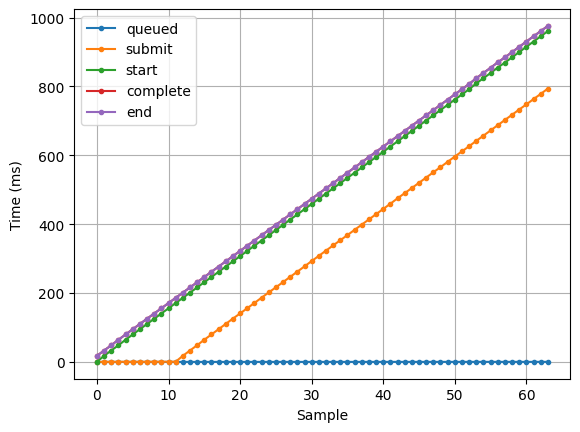

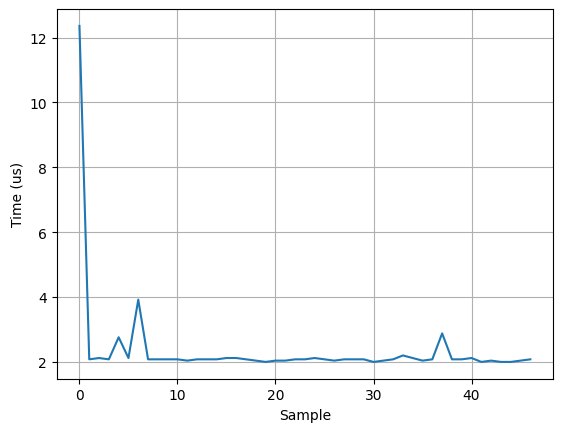

dispatch_delay_median=2.080us


In [6]:
def get_profiling_info(ev):
    keys = [
        "COMPLETE",
        "END",
        "QUEUED",
        "START",
        "SUBMIT",
    ]
    return { key.lower(): ev.get_profiling_info(getattr(cl.profiling_info, key)) for key in keys }
    
ns_per_tick = device_info["profiling_timer_resolution"]

profile_info = [get_profiling_info(ev) for ev in kernel_events]
event_types = list(profile_info[0].items())
event_types = sorted(event_types, key=lambda x: x[1])
event_types = [k for k,v in event_types]
print(event_types)

total_events = len(event_types)
N = len(profile_info)
Y = np.zeros((total_events, N), dtype=np.float64)
X = np.arange(len(profile_info))

for j, key in enumerate(event_types):
    y = Y[j]
    for i, info in enumerate(profile_info):
        time_ticks = info[key]
        time_ns = ns_per_tick*time_ticks
        y[i] = time_ns

Y -= np.min(Y)

plt.figure()
# i = slice(64, 64+10)
i = slice(0, N)
for j, key in enumerate(event_types):
    # if j <= 1: continue
    plt.plot(X[i], Y[j,i] * 1e-6, label=key, marker=".")
plt.grid(True)
plt.legend()
plt.xlabel("Sample")
plt.ylabel("Time (ms)")
plt.show()

delay_dispatch_ns = Y[2,1:] - Y[3,:-1] 
plt.figure()
plt.plot(delay_dispatch_ns[:-16]*1e-3)
plt.grid()
plt.xlabel("Sample")
plt.ylabel(f"Time (us)")
plt.show()

# print(f"dispatch_delay_median={np.median(delay_dispatch_ns)*1e-3:.3f}us")
print(f"dispatch_delay_median={np.median(delay_dispatch_ns)*1e-3:.3f}us")

In [7]:
y_cpu_out = np.zeros(data_shape, dtype=y_cpu.dtype)
total_loops = 16
compute_complexity = 32

cpu_net_ns = 0
for _ in tqdm(range(total_loops)):
    a = np.arange(total_cells, dtype=np.float32)
    b = np.full(data_shape, 1.3, dtype=np.float32) 
    # ignore malloc overhead
    with NanoTimer() as timer:
        for _ in range(compute_complexity):
            a = b*a + b
            b = a*b + a
        y_cpu_out = b
    cpu_net_ns += timer.get_delta_ns()
cpu_pass_ns = cpu_net_ns / total_loops
cpu_cell_rate = total_cells / (cpu_pass_ns*1e-9)
cpu_flop_rate = cpu_cell_rate * flops_per_cell * compute_complexity

print("=== CPU ===")
print(f"cpu_net_time={cpu_net_ns*1e-6:.3f} ms")
print(f"cpu_pass_time={cpu_pass_ns*1e-6:.3f} ms")
print(f"cpu_cell_rate={cpu_cell_rate*1e-6:.3f} M/s")
print(f"cpu_flops={cpu_flop_rate*1e-9:.3f} GFlops")

print(f"speed_up={gpu_flop_rate/cpu_flop_rate:.3f}x")

print("=== Validation ===")
error = np.abs(y_gpu_out-y_cpu_out)
error_avg = np.mean(error)
error_max = np.max(error)
print(f"error_avg={error_avg:.3e}")
print(f"error_max={error_max:.3e}")

n_read = 4
print(y_gpu_out[:n_read])
print(y_cpu_out[:n_read])

C:\Users\acidi\AppData\Local\Temp\ipykernel_27104\1641252954.py:13: RuntimeWarning: overflow encountered in multiply
  b = a*b + a
C:\Users\acidi\AppData\Local\Temp\ipykernel_27104\1641252954.py:12: RuntimeWarning: overflow encountered in multiply
  a = b*a + b
100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

=== CPU ===
cpu_net_time=6464.929 ms
cpu_pass_time=404.058 ms
cpu_cell_rate=7.785 M/s
cpu_flops=0.997 GFlops
speed_up=3387.320x
=== Validation ===
error_avg=nan
error_max=nan
[inf inf inf inf]
[inf inf inf inf]



C:\Users\acidi\AppData\Local\Temp\ipykernel_27104\1641252954.py:29: RuntimeWarning: invalid value encountered in subtract
  error = np.abs(y_gpu_out-y_cpu_out)
